In [20]:
#In Jupyter notebooks, you will need to run this command before doing any plotting
%matplotlib inline
import matplotlib.image as mpimg
from sutils import *
#from psutil import *
import os, json
from os import walk
from glob import glob

from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model,load_model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau


In [2]:
limit_gpu_mem()

In [3]:
path = "data/pokemon/"

In [17]:
batch_size=16
no_of_epochs=50

In [6]:
# Prepare images for training in batches
# NB: They must be in subdirectories named based on their category
batches = get_batches(path+'train', batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size*2)

Found 165 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


This will download the Inception weights from
https://github.com/fchollet/deep-learning-models/releases/download/v0.5/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

In [7]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

In [8]:
base_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, None, None, 32 864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, None, None, 32 96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, None, None, 32 0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [9]:
print(base_model.output)

Tensor("mixed10/concat:0", shape=(?, ?, ?, 2048), dtype=float32)


In [10]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 2 classes
predictions = Dense(2, activation='softmax')(x)


In [11]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [12]:
print(base_model.input)
model.summary()

Tensor("input_1:0", shape=(?, ?, ?, 3), dtype=float32)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, None, None, 32 864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, None, None, 32 96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, None, None, 32 0           batch_normalization_1[0][0]      
____________________________________

In [13]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    print(layer.name)
    layer.trainable = False


input_1
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
conv2d_3
batch_normalization_3
activation_3
max_pooling2d_1
conv2d_4
batch_normalization_4
activation_4
conv2d_5
batch_normalization_5
activation_5
max_pooling2d_2
conv2d_9
batch_normalization_9
activation_9
conv2d_7
conv2d_10
batch_normalization_7
batch_normalization_10
activation_7
activation_10
average_pooling2d_1
conv2d_6
conv2d_8
conv2d_11
conv2d_12
batch_normalization_6
batch_normalization_8
batch_normalization_11
batch_normalization_12
activation_6
activation_8
activation_11
activation_12
mixed0
conv2d_16
batch_normalization_16
activation_16
conv2d_14
conv2d_17
batch_normalization_14
batch_normalization_17
activation_14
activation_17
average_pooling2d_2
conv2d_13
conv2d_15
conv2d_18
conv2d_19
batch_normalization_13
batch_normalization_15
batch_normalization_18
batch_normalization_19
activation_13
activation_15
activation_18
activation_19
mixed1
conv2d_23
batch_normalization_23
activat

In [14]:
for layer in model.layers:
    print(layer.name)
    print(layer.trainable)

input_1
False
conv2d_1
False
batch_normalization_1
False
activation_1
False
conv2d_2
False
batch_normalization_2
False
activation_2
False
conv2d_3
False
batch_normalization_3
False
activation_3
False
max_pooling2d_1
False
conv2d_4
False
batch_normalization_4
False
activation_4
False
conv2d_5
False
batch_normalization_5
False
activation_5
False
max_pooling2d_2
False
conv2d_9
False
batch_normalization_9
False
activation_9
False
conv2d_7
False
conv2d_10
False
batch_normalization_7
False
batch_normalization_10
False
activation_7
False
activation_10
False
average_pooling2d_1
False
conv2d_6
False
conv2d_8
False
conv2d_11
False
conv2d_12
False
batch_normalization_6
False
batch_normalization_8
False
batch_normalization_11
False
batch_normalization_12
False
activation_6
False
activation_8
False
activation_11
False
activation_12
False
mixed0
False
conv2d_16
False
batch_normalization_16
False
activation_16
False
conv2d_14
False
conv2d_17
False
batch_normalization_14
False
batch_normalization_17
F

In [15]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [16]:

test = batches.next()

print(len(test[1][0]))
print(test[1][2])

2
[ 0.  1.]


In [22]:
# define the checkpoint callback
filepath="checkpoints/transferlearning-pokemon-weights-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
reduce_LR = ReduceLROnPlateau(monitor='val_loss',factor = 0.5, patience=3,cooldown=2, min_lr = 0.00001, mode='auto')
callbacks_list = [checkpoint,reduce_LR]

In [35]:
hist = model.fit_generator(batches, steps_per_epoch=80, epochs=no_of_epochs,verbose=1,
                validation_data=val_batches, validation_steps=3, callbacks=callbacks_list)

Epoch 1/50
80/80 [==============================] - 343s - loss: 0.1886 - acc: 0.9274 - val_loss: 0.4308 - val_acc: 0.8000
Epoch 2/50
80/80 [==============================] - 344s - loss: 0.0478 - acc: 0.9816 - val_loss: 0.2597 - val_acc: 0.9333
Epoch 3/50
80/80 [==============================] - 342s - loss: 0.0827 - acc: 0.9682 - val_loss: 0.3855 - val_acc: 0.9333
Epoch 4/50
80/80 [==============================] - 339s - loss: 0.0626 - acc: 0.9786 - val_loss: 0.0187 - val_acc: 1.0000
Epoch 5/50
80/80 [==============================] - 341s - loss: 0.0564 - acc: 0.9791 - val_loss: 0.4914 - val_acc: 0.8667
Epoch 6/50
80/80 [==============================] - 341s - loss: 0.0912 - acc: 0.9692 - val_loss: 0.0173 - val_acc: 1.0000
Epoch 7/50
80/80 [==============================] - 339s - loss: 0.0364 - acc: 0.9840 - val_loss: 0.0507 - val_acc: 0.9667
Epoch 8/50
80/80 [==============================] - 339s - loss: 0.0252 - acc: 0.9920 - val_loss: 0.0726 - val_acc: 0.9667
Epoch 9/50
80/80

80/80 [==============================] - 339s - loss: 0.0098 - acc: 0.9975 - val_loss: 0.0267 - val_acc: 1.0000
Epoch 34/50
80/80 [==============================] - 343s - loss: 0.0305 - acc: 0.9876 - val_loss: 0.0468 - val_acc: 0.9667
Epoch 35/50
80/80 [==============================] - 341s - loss: 0.0080 - acc: 0.9952 - val_loss: 0.0307 - val_acc: 0.9667
Epoch 36/50
80/80 [==============================] - 346s - loss: 0.0152 - acc: 0.9935 - val_loss: 0.0253 - val_acc: 1.0000
Epoch 37/50
80/80 [==============================] - 338s - loss: 0.0174 - acc: 0.9950 - val_loss: 0.0274 - val_acc: 1.0000
Epoch 38/50
80/80 [==============================] - 342s - loss: 0.0043 - acc: 0.9992 - val_loss: 0.0290 - val_acc: 1.0000
Epoch 39/50
80/80 [==============================] - 342s - loss: 0.0615 - acc: 0.9819 - val_loss: 0.0243 - val_acc: 1.0000
Epoch 40/50
80/80 [==============================] - 338s - loss: 0.0135 - acc: 0.9960 - val_loss: 0.0273 - val_acc: 1.0000
Epoch 41/50
80/80 [=

In [37]:
metrics = model.evaluate_generator(val_batches,10,10,workers=1,pickle_safe=False)
print(metrics)
print("model accuracy:",metrics[1])

C:\Users\Superical\Anaconda3\envs\tensorflow13\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `evaluate_generator` call to the Keras 2 API: `evaluate_generator(<keras.pre..., 10, 10, workers=1, use_multiprocessing=False)`
  """Entry point for launching an IPython kernel.


[0.023469311371445655, 1.0]
model accuracy: 1.0


In [36]:
model.save('model/pokemon-charizardorpikachu.hdf5')

In [55]:
model = load_model('model/pokemon-charizardorpikachu.hdf5')

In [24]:
image_path = './data/pokemon/test/'

In [25]:
def show_image(name):
    img_path = os.path.join(image_path, name)
    img=mpimg.imread(img_path)
    plt.imshow(img)

In [59]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
import numpy as np

#name = 'charizard/3.jpg'
name = 'pikachu/pikachua-charizardhat.jpg'

img_path = os.path.join(image_path, name)
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)

Input image shape: (1, 299, 299, 3)


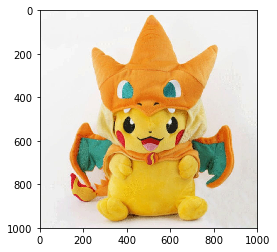

In [60]:
show_image(name)

In [61]:
preds = model.predict(x)
print('Predicted:', preds)

Predicted: [[ 0.49617741  0.50382262]]


In [62]:
result= np.argmax(preds)
if result==0:
    print("It's a Charizard!")
else:
    print("It's Pikachu!")

It's Pikachu!
